In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import random
import os,shutil
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D,ZeroPadding2D
from __future__ import print_function

import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing import image

from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import GlobalAveragePooling2D



TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels.h5'
src_path="../input"

print(os.listdir(src_path))

#constant value
VALID_SPIT=0.2
IMAGE_SIZE=80
BATCH_SIZE=20

['test1', 'sampleSubmission.csv', 'train']


Using TensorFlow backend.


In [2]:
label=[]
data=[]
counter=0
path="../input/train/train"
for file in os.listdir(path):
    image_data=cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)
    image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
    if file.startswith("cat"):
        label.append(0)
    elif file.startswith("dog"):
        label.append(1)
    try:
        data.append(image_data/255)
    except:
        label=label[:len(label)-1]
    counter+=1
    if counter%1000==0:
        print (counter," image data retreived")

data=np.array(data)
data=data.reshape((data.shape)[0],(data.shape)[1],(data.shape)[2],3)
label=np.array(label)
print (data.shape)
print (label.shape)


1000  image data retreived
2000  image data retreived
3000  image data retreived
4000  image data retreived
5000  image data retreived
6000  image data retreived
7000  image data retreived
8000  image data retreived
9000  image data retreived
10000  image data retreived
11000  image data retreived
12000  image data retreived
13000  image data retreived
14000  image data retreived
15000  image data retreived
16000  image data retreived
17000  image data retreived
18000  image data retreived
19000  image data retreived
20000  image data retreived
21000  image data retreived
22000  image data retreived
23000  image data retreived
24000  image data retreived
25000  image data retreived
(25000, 80, 80, 3)
(25000,)


In [3]:
from sklearn.model_selection import train_test_split
train_data, valid_data, train_label, valid_label = train_test_split(
    data, label, test_size=0.2, random_state=42)
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

(20000, 80, 80, 3)
(20000,)
(5000, 80, 80, 3)
(5000,)


In [15]:
def VGG19(include_top=True, weights='imagenet',
          input_tensor=None):
   
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, None, None)
    else:
        if include_top:
            input_shape = (80, 80, 3)
        else:
            input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    if include_top:
        x = Flatten(name='flatten')(x)
        x = Dense(256, activation='relu', name='fc2')(x)
        x = Dense(1, activation='sigmoid', name='predictions')(x)

    # Create model
    model = Model(img_input, x)
    if weights == 'imagenet':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('vgg19_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models')

    return model

In [18]:

model = VGG19(include_top=True, weights=None)
model.summary()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", name="block3_conv1", padding="

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0         
__________

In [19]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])


train_history=model.fit(train_data, train_label,validation_data=(valid_data,valid_label),epochs=20, batch_size=BATCH_SIZE)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 46s 2ms/step - loss: 0.6935 - acc: 0.5007 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 2/20
20000/20000 [==============================] - 43s 2ms/step - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.4964
Epoch 3/20
20000/20000 [==============================] - 43s 2ms/step - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.4964
Epoch 4/20
20000/20000 [==============================] - 43s 2ms/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 5/20
20000/20000 [==============================] - 44s 2ms/step - loss: 0.6932 - acc: 0.4930 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 6/20
20000/20000 [==============================] - 43s 2ms/step - loss: 0.6931 - acc: 0.5054 - val_loss: 0.6932 - val_acc: 0.4964
Epoch 7/20
20000/20000 [==============================] - 43s 2ms/step - loss: 0.6933 - acc: 0.4992 - val_loss: 0.6932 - val_acc:

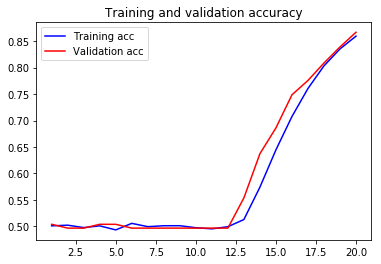

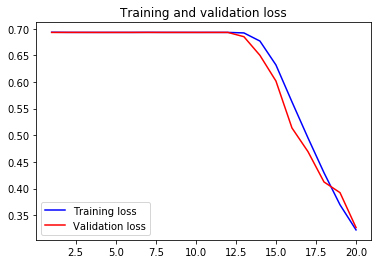

In [20]:
import matplotlib.pyplot as plt
acc = train_history.history['acc']
val_acc = train_history.history['val_acc']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
from keras import Sequential
from keras.layers import *
import keras.optimizers as optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
import keras.backend as K
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory("../input/test1",target_size=(80, 80),batch_size=32,class_mode='binary')

Found 12500 images belonging to 1 classes.


In [22]:
from tensorflow.python.keras.models import Sequential
from keras.models import load_model

print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 100)

-- Evaluate --


In [23]:
Y_pred = model.predict(valid_data)
predicted_label=np.round(Y_pred,decimals=2)

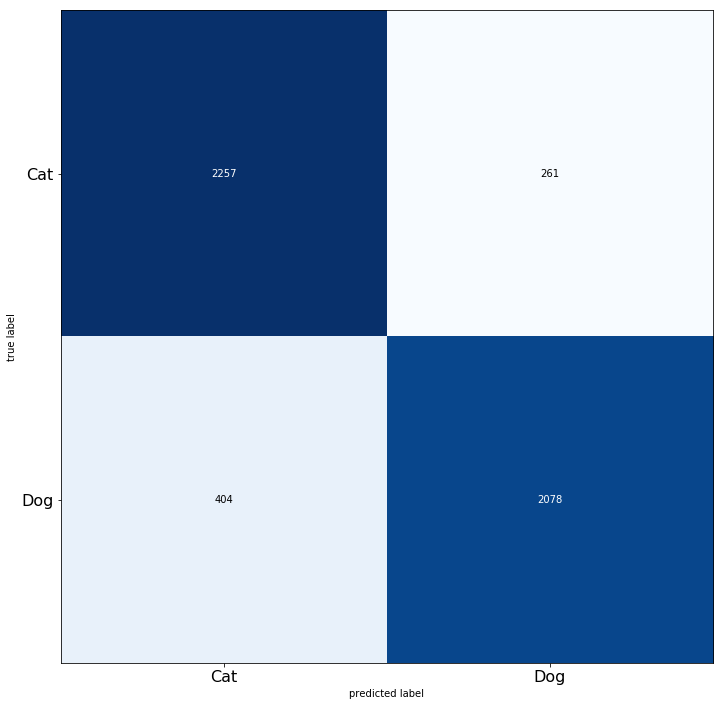

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

# Get the confusion matrix

CM = confusion_matrix(valid_label, Y_pred.round())
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 12))
plt.xticks(range(2), ['Cat', 'Dog'], fontsize=16)
plt.yticks(range(2), ['Cat', 'Dog'], fontsize=16)
plt.show()

In [25]:
!pip install git+https://github.com/raghakot/keras-vis.git -U

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-fzhxwbu0
  Stored in directory: /tmp/pip-ephem-wheel-cache-iz9zlqfv/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from vis.visualization import visualize_saliency, overlay, visualize_cam
from vis.utils import utils

In [27]:
correct_indices = []
incorrect_indices = []

# separate the correctly predicted results with incorrectly predicted ones
for i in range(len(Y_pred)):
    if Y_pred.round()[i] == valid_label[i]:
        correct_indices.append(valid_data[i])
    else:
        incorrect_indices.append(valid_data[i])

correct_indices = np.array(correct_indices)
incorrect_indices = np.array(incorrect_indices)

# print('-- Correctly Predicted Results\' Indices -

In [28]:
len(correct_indices)

4335

In [29]:
len(incorrect_indices)

665

In [30]:
layer_idx = utils.find_layer_idx(model,'predictions')
penultimate_layer = utils.find_layer_idx(model,'block5_conv3')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)


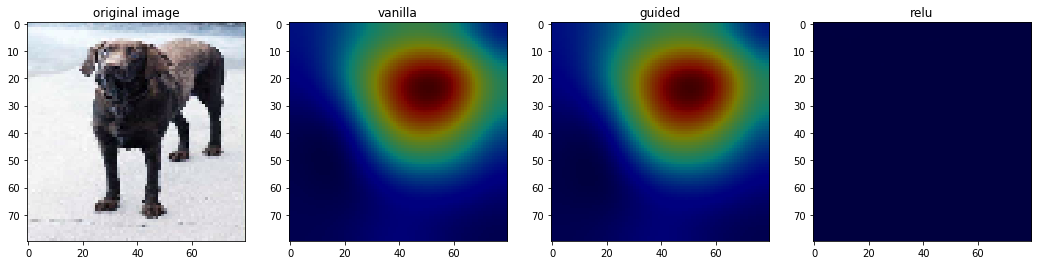

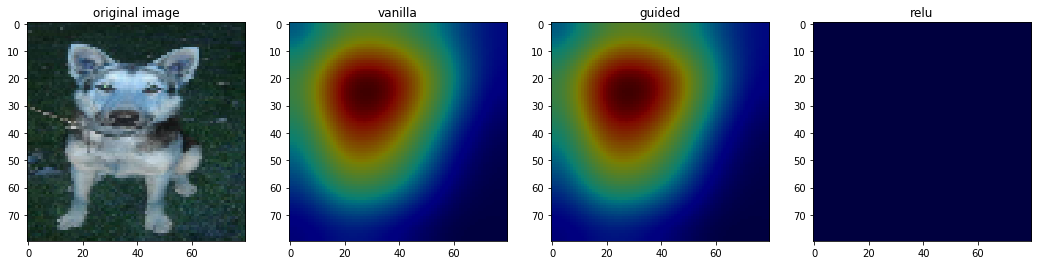

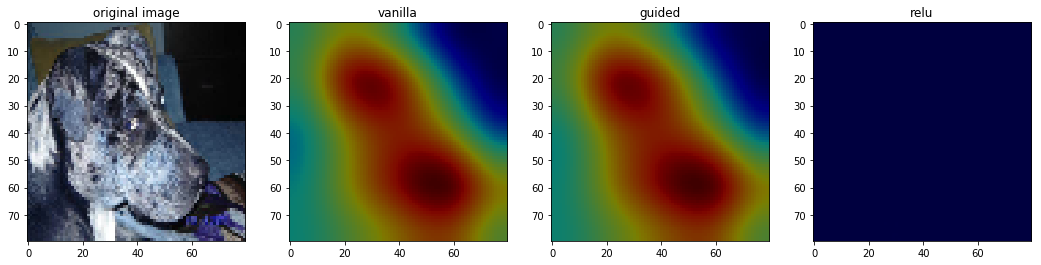

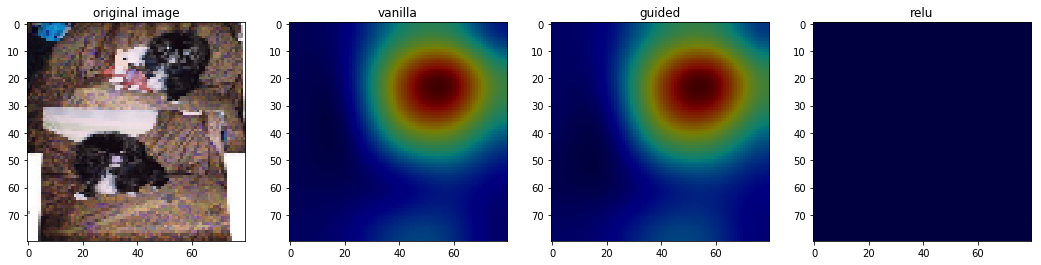

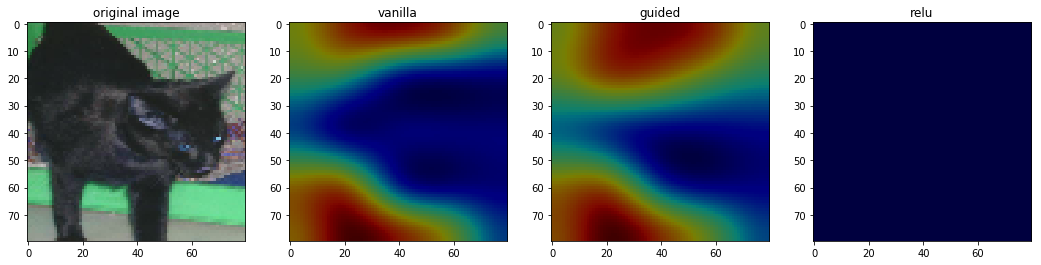

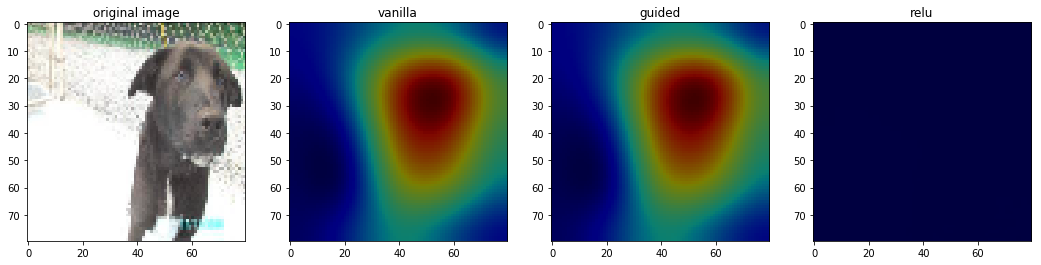

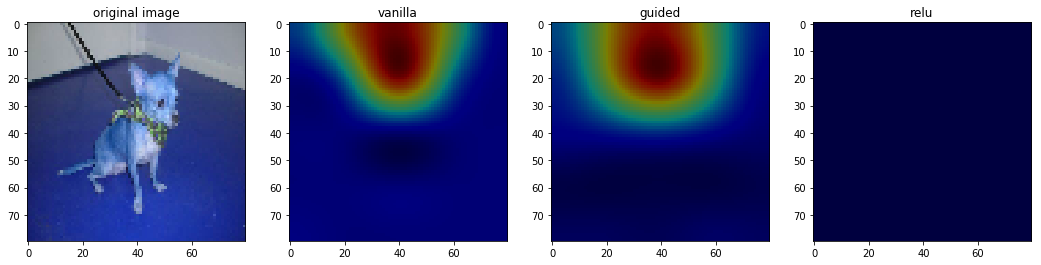

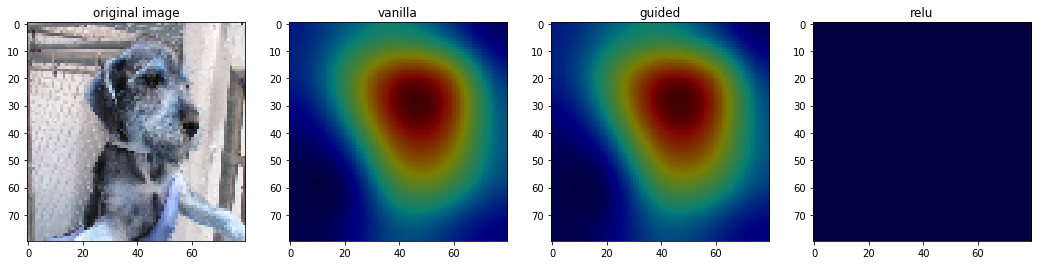

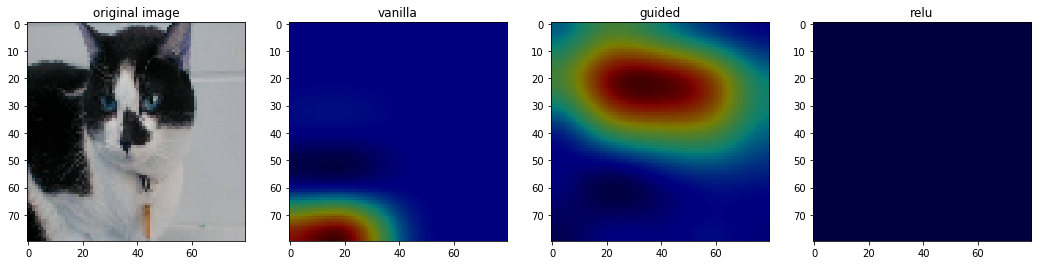

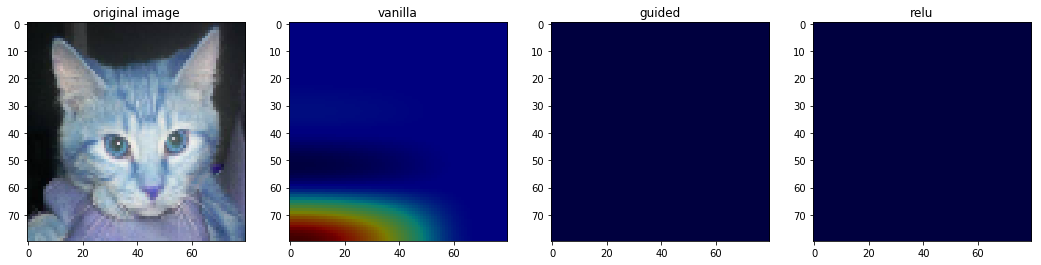

In [32]:

plt.rcParams['figure.figsize'] = (18, 6)
for i in range(-5, 5):

    f, ax = plt.subplots(1, 4)
    ax[0].set_title('original image')
    ax[0].imshow(valid_data[i])
  
    for j, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices = 0, seed_input = valid_data[i], penultimate_layer_idx = penultimate_layer, backprop_modifier = modifier)
    
        if modifier is None:
            modifier = 'vanilla'

        ax[j + 1].set_title(modifier)
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[j + 1].imshow(overlay(jet_heatmap, valid_data[i]))